**Mounting the Drive**


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Required Libraries**

In [2]:
%matplotlib inline

In [3]:
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
from natsort import natsorted

**Define Model**

In [ ]:
#Resizing images is optional, CNNs are ok with large images
SIZE_X = 128 #Resize images (height  = X, width = Y)
SIZE_Y = 128
OGX = 3000
OGY = 1700


**Testing Area**

In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/Sclera_Project_Files/Sclera/Sclera_140.h5', compile=False)

**Upload & Read Image**

1/1 [==============================] - 0s 56ms/step


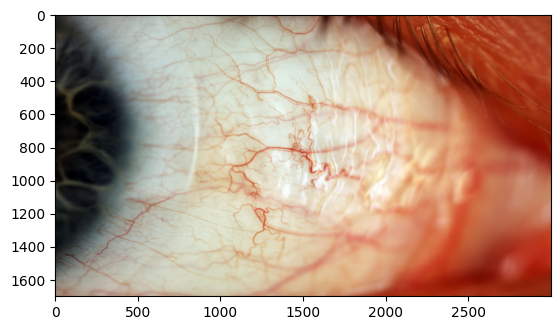

In [ ]:

#Test on a different image
#READ EXTERNAL IMAGE...
test_img = cv2.imread('/content/drive/MyDrive/Sclera_Project_Files/Input/test2.jpg', cv2.IMREAD_COLOR)
test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
test_image = test_img
test_img = cv2.resize(test_img, (SIZE_Y, SIZE_X))


test_img = np.expand_dims(test_img, axis=0)

prediction = model.predict(test_img)

test_image = cv2.resize(test_image, (OGX, OGY))
plt.imshow(test_image)



**Segmentate Mask**

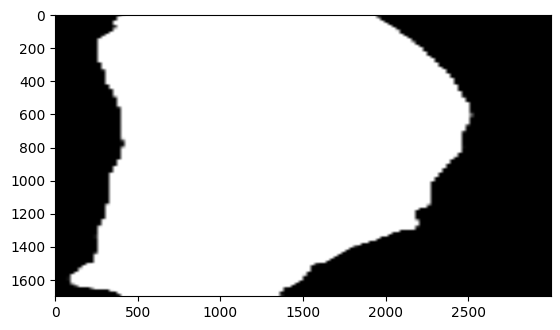

In [ ]:
#View and Save segmented image
prediction_image = prediction.reshape((SIZE_X,SIZE_Y))

prediction_image = cv2.resize(prediction_image, (OGX, OGY))
plt.imshow(prediction_image, cmap='gray')
plt.imsave('/content/drive/MyDrive/Sclera_Project_Files/Testing/segmented2.jpg', prediction_image, cmap='gray')


**Segmentated Mask + Image**

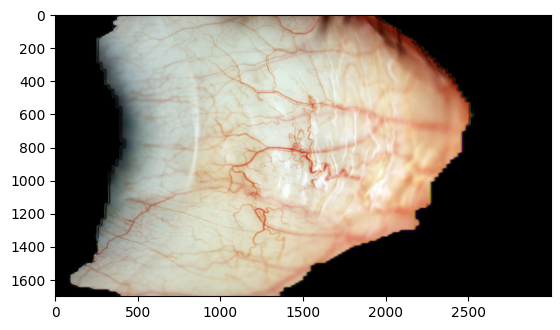

In [ ]:
imgg = cv2.imread('/content/drive/MyDrive/Sclera_Project_Files/Testing/segmented2.jpg')

#imgg2 = cv2.resize(imgg2, (SIZE_Y, SIZE_X))
imgg = cv2.resize(imgg, (OGX, OGY))
imgg =  cv2.cvtColor(imgg, cv2.COLOR_RGB2BGR)
annd = cv2.bitwise_and(imgg, test_image)
plt.imshow(annd, cmap='gray')

**Sclera Segmentation**

/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)


True

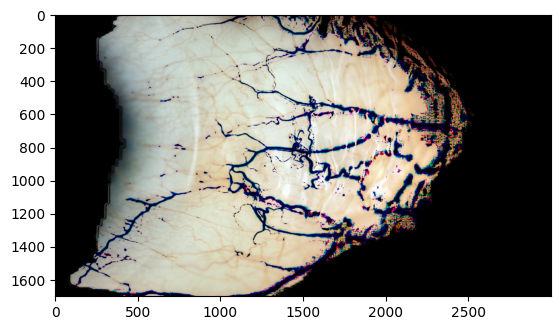

In [ ]:
from skimage.filters import frangi, hessian



image = test_image
#image = cv2.imread('/content/53L_s_1.jpg', cv2.IMREAD_COLOR)
seg=(hessian(image) )

plt.imsave('/content/drive/MyDrive/Sclera_Project_Files/Output/final2.jpg', seg, cmap='gray')

seg2= cv2.imread('/content/drive/MyDrive/Sclera_Project_Files/Output/final2.jpg')

annd2 = cv2.bitwise_and(seg2, annd)
plt.imshow(annd2, cmap='gray')
cv2.imwrite('/content/drive/MyDrive/Sclera_Project_Files/Verification/annd2_result2.jpg', annd2)
# 1m.58s

**SIFT FEATURE EXTRACTION**


Probe Image Keypoints: 9170
Reference Image Keypoints: 11139
Probe Image Descriptors: (9170, 128)
Reference Image Descriptors: (11139, 128)


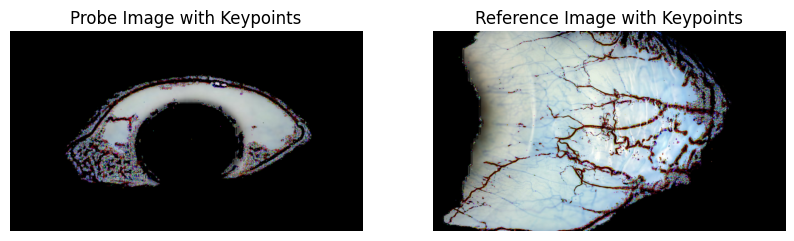

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the probe and reference images (make sure they are properly defined)
probe_image = cv2.imread('/content/drive/MyDrive/Sclera_Project_Files/Verification/annd2_result1.jpg')
reference_image = cv2.imread('/content/drive/MyDrive/Sclera_Project_Files/Verification/annd2_result2.jpg')

# Convert the images to grayscale
probe_gray = cv2.cvtColor(probe_image, cv2.COLOR_BGR2GRAY)
reference_gray = cv2.cvtColor(reference_image, cv2.COLOR_BGR2GRAY)

# Initialize the SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and compute SIFT descriptors for both images
keypoints_probe, descriptors_probe = sift.detectAndCompute(probe_gray, None)
keypoints_reference, descriptors_reference = sift.detectAndCompute(reference_gray, None)

# Print the number of keypoints and descriptors
print("Probe Image Keypoints:", len(keypoints_probe))
print("Reference Image Keypoints:", len(keypoints_reference))
print("Probe Image Descriptors:", descriptors_probe.shape)
print("Reference Image Descriptors:", descriptors_reference.shape)

# Draw keypoints on the images
probe_image_with_keypoints = cv2.drawKeypoints(probe_image, keypoints_probe, None)
reference_image_with_keypoints = cv2.drawKeypoints(reference_image, keypoints_reference, None)

# Display the images with keypoints using matplotlib
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(probe_image_with_keypoints, cv2.COLOR_BGR2RGB))
plt.title('Probe Image with Keypoints')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(reference_image_with_keypoints, cv2.COLOR_BGR2RGB))
plt.title('Reference Image with Keypoints')
plt.axis('off')

plt.show()



**VERIFICATION USING SVM**


In [9]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

# Assuming you have SIFT descriptors in descriptors_probe and descriptors_reference
probe_features = descriptors_probe
reference_features = descriptors_reference

# Combine the features and labels
combined_features = np.concatenate((probe_features, reference_features))

# Create labels for one positive (matching) and one negative (non-matching) example
labels = np.array([1] * len(probe_features) + [0] * len(reference_features))

# Initialize and train an SVM model with a linear kernel
max_iter = 1000  # Adjust the number of iterations as needed
svm_model = SVC(kernel='linear', max_iter=max_iter)
svm_model.fit(combined_features, labels)

# Predict using the trained SVM model
predictions = svm_model.predict(combined_features)

# Calculate accuracy
accuracy = accuracy_score(labels, predictions)
print("Accuracy:", accuracy)

# Define a function to perform image verification
def verify_images(probe_features, reference_features, svm_model):
    # Predict using the trained SVM model
    prediction = svm_model.predict(np.concatenate((probe_features, reference_features)))

    # If all predictions are 1, it's a successful verification
    if np.all(prediction == 1):
        print("Verification successful: The images match.")
    else:
        print("Verification failed: The images do not match.")

# Verify images
verify_images(descriptors_probe, descriptors_reference, svm_model)


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Accuracy: 0.5630016248953665
Verification failed: The images do not match.
